# DrEyeBot Retinal Image Analysis using CNN

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import datetime
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import imutils
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from shutil import copyfile

import pandas as pd
import cv2
import seaborn as sn

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import model_from_json
from keras import applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.initializers import glorot_normal
from keras import losses

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop,SGD
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15134986333140404048
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4635295493171668838
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16153903698557125159
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15560690893
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10351567175164560907
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


## Common Functions

### Helper Functions

In [4]:
def levelset(x):
    """ Sets Levels 1-4 to level 1"""
    if x>0:
        return 1
    else:
        return 0

def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

def select_toy_images(image_label,N=-1,images_percent=list()):
    """ Selects number of images from each class. By default it is ALL images"""
    image_list = list()
    final_images = pd.DataFrame(columns = image_label.columns)
    # We create a toy dataset of 'N' images, maintaining the split of the original 
    if N==-1:
            # We need to pick all the images. No need to sample
            # We can ignore the percentage here
            final_images = image_label
    else:
        for level in range(5):
        # Get respective number of images in each level
            if len(images_percent)==5:
                number_of_images = int(images_percent[level]*N/100)
            else:
                # We have no percentage of images. Setting the default safe percentage
                images_percent = [73.6,6.9,15.1,2.4,2]
                number_of_images = int(images_percent[level]*N/100)
            sample_images = image_label[image_label.level==level].sample(n=number_of_images,axis=0)
            frames = [final_images,sample_images]
            final_images = pd.concat(frames).reset_index(drop=True)
    return final_images 

def preprocess(image,scale=224):
    """ preprocess the test image and covert to array """
    inter=cv2.INTER_AREA
    (h, w) = image.shape[:2]
    dW = 0
    dH = 0

    width = scale
    height = scale

    # if the width is smaller than the height, then resize
    # along the width (i.e., the smaller dimension) and then
    # update the deltas to crop the height to the desired
    # dimension
    if w < h:
        image = imutils.resize(image, width=width,
            inter=inter)
        dH = int((image.shape[0] - height) / 2.0)

    # otherwise, the height is smaller than the width so
    # resize along the height and then update the deltas
    # crop along the width
    else:
        image = imutils.resize(image, height=height,
            inter=inter)
        dW = int((image.shape[1] - width) / 2.0)

    # now that our images have been resized, we need to
    # re-grab the width and height, followed by performing
    # the crop
    (h, w) = image.shape[:2]
    image = image[dH:h - dH, dW:w - dW]

    # finally, resize the image to the provided spatial
    # dimensions to ensure our output image is always a fixed
    # size

    image =  cv2.resize(image, (width, height),
        interpolation=inter)
    image_arr = img_to_array(image)
    image_arr = image_arr/255.0
    return img_to_array(image_arr)

def selector(x):
    """ Function to select the class"""
    if x[0] > x[1]:
        return 0
    else:
        return 1

### Model related functions

In [5]:
def OrdinalLoss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * losses.categorical_crossentropy(y_true, y_pred)

def OrdinalLoss_new(y_true,y_pred,train_out):
    """ Custom loss Function for Ordinal Data"""
    num_classes=5
    dx = np.ones((num_classes,1)) * np.arange(num_classes)
    dy = dx.transpose()
    d = np.sqrt(abs(dx - dy))
    overestimate_penalty = np.triu(d[:,1:]) / (np.spacing(1) + 
                                               (np.sum(np.triu(d[:,1:]), axis=1)/
                                                (np.arange(num_classes)[::-1]+np.spacing(1))).reshape((5,1)))
    underestimate_penalty = overestimate_penalty[::-1, ::-1]
    overestimate_penalty = tf.convert_to_tensor(overestimate_penalty, np.float32)
    underestimate_penalty = tf.convert_to_tensor(underestimate_penalty, np.float32)
    #loss_train = -K.mean(K.sum((underestimate_penalty[y_pred])*K.log(train_out) + (overestimate_penalty[y_pred])*K.log(1-train_out), axis=1))
    loss_train = K.binary_crossentropy(y_true, y_pred)
    loss_val = K.binary_crossentropy(y_true, y_pred)
    return K.in_train_phase(loss_train, loss_val)

def LossWrapper(train_out):
    def customLoss(y_true, y_pred):
        return OrdinalDataLoss_new(y_true, y_pred, train_out)
    return customLoss

In [6]:
def InceptionResNetV2(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ InceptionResNet with transfer learning. Using Keras built in function"""
    model = applications.inception_resnet_v2.InceptionResNetV2(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def Resnet101V2(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ Resnet50 with transfer learning. Using Keras built in function"""
    model = applications.resnet_v2.ResNet101V2(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def Resnet50V2(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ Resnet50 with transfer learning. Using Keras built in function"""
    model = applications.resnet_v2.ResNet50V2(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def Resnetv1(input_shape,depth=50,layers_to_skip=None,weights=None,include_top=True):
    """ Resnet50 with transfer learning. Using Keras built in function"""
    
    if depth==50:
        model = applications.resnet50.ResNet50(weights = weights, include_top=include_top, input_shape = input_shape)
    elif depth == 101:
        model = applications.resnet101.ResNet101(weights = weights, include_top=include_top, input_shape = input_shape)
    else:
        model = applications.resnet152.ResNet152(weights = weights, include_top=include_top, input_shape = input_shape)
        
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    #model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def VGG_16_TL(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ VGG 16 with Transfer Learning. Using Keras built in function"""
    model = applications.VGG16(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def VGG_19_TL(input_shape,layers_to_skip=None,weights=None,include_top=True):
    """ VGG 19 with Transfer Learning. Using Keras built in function"""
    model = applications.VGG19(weights = weights, include_top=include_top, input_shape = input_shape)
    if layers_to_skip:
        if weights==None:
            print("ERROR: You cannot have weights as none if layers_to_skip is non-zero")
        else:
            for layer in model.layers[:layers_to_skip]:
                layer.trainable = False
            #Adding custom Layers 
            x = model.output
            x = Flatten()(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(4096, activation="relu")(x)
            x = Dropout(0.5)(x)
    else:
        x = model.output
    
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model_final

def VGG_16(weights_path=None):
    initializer = glorot_normal()
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),input_shape=(length,width,depth),
                     activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu',kernel_initializer=initializer))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu',kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu',kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    #x = model.output
    #custom_loss = LossWrapper(train_out=x)
    # compile model
    model.compile(loss=OrdinalLoss,optimizer = sgd, metrics = ['accuracy'])
    #model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model.summary())
    return model

def CNN_FF():
    """ CNN with Feed Forward NN """
    model_conv = Sequential()
    model_conv.add(Conv2D(32, kernel_size=(5, 5), 
                                          input_shape=(length,width,depth),activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Conv2D(64, (5, 5), activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Flatten())
    model_conv.add(Dense(100))
    model_conv.add(Dropout(0.1))
    model_conv.add(Dense(num_classes, activation='softmax'))
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model_conv.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model_conv.summary())
    return model_conv


def save_model(model,vgg=True):
    # saving model
    json_model = model.to_json()
    # Get today's date. We will use this as string for filename
    now = datetime.datetime.now()
    day = str(now)[:10]
    if vgg:
        arch_name = 'model_architecture_vgg_'+day+'35K_aug'+'.json'
        model_weights = 'model_weights_vgg_'+day+'35K_aug'+'.h5'
    else:
        arch_name = 'model_architecture_s_cnn'+day+'.json'
        model_weights = 'model_weights_s_cnn'+day+'.h5'
        
    open(arch_name, 'w').write(json_model)
    # saving weights
    model.save_weights(model_weights, overwrite=True)

def load_model(model_arch,model_weights):
    # loading model
    model = model_from_json(open(model_arch).read())
    model.load_weights(model_weights)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

## LOAD DATA

In [7]:
# Load the csv data
orig_label = pd.read_csv("./Retinal-Images/trainLabels.csv")
# Load the test csv data
test_label = pd.read_csv("./Retinal-Images/retinopathy_solution.csv")
test_label.drop('Usage',inplace=True,axis=1)

In [8]:
orig_label.count()

image    35126
level    35126
dtype: int64

In [9]:
test_label.count()

image    53576
level    53576
dtype: int64

In [10]:
orig_label.groupby(['level']).count()

,image
level,
0,25810
1,2443
2,5292
3,873
4,708


In [11]:
test_label.groupby(['level']).count()

,image
level,
0,39533
1,3762
2,7861
3,1214
4,1206


### DATA PREPERATION

In [12]:
l4_orig_df = orig_label[orig_label.level==4].sample(200,random_state=42)
l3_orig_df = orig_label[orig_label.level==3].sample(500,random_state=42)
l2_orig_df = orig_label[orig_label.level==2].sample(500,random_state=42)
l1_orig_df = orig_label[orig_label.level==1].sample(500,random_state=42)
l0_orig_df = orig_label[orig_label.level==0].sample(3300,random_state=42)
rest_orig_df = pd.concat([orig_label, l4_orig_df,l3_orig_df,
                          l2_orig_df,l1_orig_df,l0_orig_df]).drop_duplicates(keep=False)
len(rest_orig_df)

30126

In [13]:
l4_test_df = test_label[test_label.level==4].sample(200,random_state=42)
l3_test_df = test_label[test_label.level==3].sample(500,random_state=42)
l2_test_df = test_label[test_label.level==2].sample(500,random_state=42)
l1_test_df = test_label[test_label.level==1].sample(500,random_state=42)
l0_test_df = test_label[test_label.level==0].sample(3300,random_state=42)
rest_test_df = pd.concat([test_label, l4_test_df,l3_test_df,
                          l2_test_df,l1_test_df,l0_test_df]).drop_duplicates(keep=False)
len(rest_test_df)

48576

### Save the dataframes so that same sets can be loaded at a later point

In [14]:
l4_orig_df.to_pickle("./l4_orig_df.pkl")
l3_orig_df.to_pickle("./l3_orig_df.pkl")
l2_orig_df.to_pickle("./l2_orig_df.pkl")
l2_orig_df.to_pickle("./l1_orig_df.pkl")
l0_orig_df.to_pickle("./l0_orig_df.pkl")
rest_orig_df.to_pickle("./rest_orig_df.pkl")

l4_test_df.to_pickle("./l4_test_df.pkl")
l3_test_df.to_pickle("./l3_test_df.pkl")
l2_test_df.to_pickle("./l2_test_df.pkl")
l2_test_df.to_pickle("./l1_test_df.pkl")
l0_test_df.to_pickle("./l0_test_df.pkl")
rest_test_df.to_pickle("./rest_test_df.pkl")

In [15]:
val_list = [l0_orig_df,l1_orig_df,l2_orig_df,l3_orig_df,l4_orig_df]
test_list = [l0_test_df,l1_test_df,l2_test_df,l3_test_df,l4_test_df]
train_list = [rest_orig_df,rest_test_df]

In [16]:
test_labels=list()
test_labels.append(list(l0_test_df.level.values))
test_labels.append(list(l1_test_df.level.values))
test_labels.append(list(l2_test_df.level.values))
test_labels.append(list(l3_test_df.level.values))
test_labels.append(list(l4_test_df.level.values))
test_labels = [item for sublist in test_labels for item in sublist]
test_labels=np.asarray(test_labels)
test_labels.shape

(5000,)

In [17]:
test_image_list=list()
test_image_list.append(list(l0_test_df.image.values))
test_image_list.append(list(l1_test_df.image.values))
test_image_list.append(list(l2_test_df.image.values))
test_image_list.append(list(l3_test_df.image.values))
test_image_list.append(list(l4_test_df.image.values))
test_image_list = [item for sublist in test_image_list for item in sublist]
test_image_list=np.asarray(test_image_list)
test_image_list.shape

(5000,)

In [18]:
val_labels=list()
val_labels.append(list(l0_orig_df.level.values))
val_labels.append(list(l1_orig_df.level.values))
val_labels.append(list(l2_orig_df.level.values))
val_labels.append(list(l3_orig_df.level.values))
val_labels.append(list(l4_orig_df.level.values))
val_labels = [item for sublist in val_labels for item in sublist]
val_labels=np.asarray(val_labels)
val_labels.shape

(5000,)

In [19]:
val_image_list=list()
val_image_list.append(list(l0_orig_df.image.values))
val_image_list.append(list(l1_orig_df.image.values))
val_image_list.append(list(l2_orig_df.image.values))
val_image_list.append(list(l3_orig_df.image.values))
val_image_list.append(list(l4_orig_df.image.values))
val_image_list = [item for sublist in val_image_list for item in sublist]
val_image_list=np.asarray(val_image_list)
val_image_list.shape

(5000,)

In [20]:
true_test_labels = np.copy(test_labels)
true_val_labels = np.copy(val_labels)
test_labels[test_labels>0]=1
val_labels[val_labels>0]=1
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
true_test_labels

array([0, 0, 0, ..., 4, 4, 4])

In [39]:
# Copy train images
# OVERSAMPLING LOGIC:
# CLASS-1 IMAGES 10X
# CLASS-2 IMAGES 5X
# CLASS-3 IMAGES 10X
# CLASS-4 IMAGES 10X

# Set this if we are using binary classification
binary_class = 1
oversample = {0:1,1:4,2:2,3:14,4:10}
#oversample = {0:1,1:10,2:5,3:30,4:25}

for i in range(2):
    if i==0:
        image_dir = os.getcwd()+'/Retinal-Images/train_resize_224_new/'
        for j in range(len(rest_orig_df)):        
            image_class = rest_orig_df.iloc[[j],[1]].values[0][0]
            image_name = rest_orig_df.iloc[[j],[0]].values[0][0]
            image_loc = image_dir+image_name+'.png'
            # Get the oversample percent for the given class
            class_oversample = oversample[image_class]
            image_class_str = image_class
            if binary_class:
                if image_class_str>0:
                    image_class_str=1
            for samples in range(class_oversample):
                class_dir = 'class_'+str(image_class_str)
                out_dir = os.getcwd()+'/Retinal-Images/train_new/'+class_dir+'/'
                copy_loc = out_dir+image_name+'-'+str(samples)+'.png'
                copyfile(image_loc,copy_loc)               
    else:
        image_dir = os.getcwd()+'/Retinal-Images/test_resize_224_new/'
        for j in range(len(rest_test_df)):        
            image_class = rest_test_df.iloc[[j],[1]].values[0][0]
            image_name = rest_test_df.iloc[[j],[0]].values[0][0]
            image_loc = image_dir+image_name+'.png'
            # Get the oversample percent for the given class
            class_oversample = oversample[image_class]
            image_class_str = image_class
            if binary_class:
                if image_class_str>0:
                    image_class_str=1
            for samples in range(class_oversample):
                class_dir = 'class_'+str(image_class_str)
                out_dir = os.getcwd()+'/Retinal-Images/train_new/'+class_dir+'/'
                copy_loc = out_dir+image_name+'-'+str(samples)+'.png'
                copyfile(image_loc,copy_loc)               

# Copy val images
for df in val_list:
    image_dir = os.getcwd()+'/Retinal-Images/train_resize_224_new/'
    for j in range(len(df)):
        image_class = df.iloc[[j],[1]].values[0][0]
        image_name = df.iloc[[j],[0]].values[0][0]
        image_loc = image_dir+image_name+'.png'
        # Get the oversample percent for the given class
        image_class_str = image_class
        if binary_class:
            if image_class_str>0:
                image_class_str=1
        class_dir = 'class_'+str(image_class_str)
        out_dir = os.getcwd()+'/Retinal-Images/val/'+class_dir+'/'
        copy_loc = out_dir+image_name+'.png'
        copyfile(image_loc,copy_loc) 

# Copy test images
for df in test_list:
    image_dir = os.getcwd()+'/Retinal-Images/test_resize_224_new/'
    for j in range(len(df)):
        image_name = df.iloc[[j],[0]].values[0][0]
        image_loc = image_dir+image_name+'.png'
        out_dir = os.getcwd()+'/Retinal-Images/test_new/test/'
        copy_loc = out_dir+image_name+'.png'
        copyfile(image_loc,copy_loc)

## TRAINING (SKIP THIS PART IF YOU HAVE SAVED MODEL)

In [22]:
# Initialize parameters
length = 224
width = 224
depth = 3
num_classes = 2
input_shape = (224,224,3)

batch_size = 100

In [23]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
         'Retinal-Images/test_new',
         target_size=(224, 224),
         batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
        'Retinal-Images/train_new',
        target_size=(224,224),
        classes = ['class_0','class_1'],
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
         'Retinal-Images/val',
         target_size=(224, 224),
         classes = ['class_0','class_1'],
         batch_size=batch_size,
         class_mode='categorical')

Found 5000 images belonging to 1 classes.
Found 134227 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [24]:
#n_train = len(rest_orig_df) + len(rest_test_df)
# Finding n_train with oversampling needs better coding. Hardcode for now
n_train = 134227
n_val = 5000
n_test = len(l0_test_df)+len(l1_test_df)+len(l2_test_df)+len(l3_test_df)+len(l4_test_df)
n_train,n_val,n_test

(134227, 5000, 5000)

In [25]:
steps_per_epoch = int(n_train/batch_size)
validation_steps = int(n_val/batch_size)
test_steps = int(n_test/batch_size)

In [26]:
train_generator.class_indices

{'class_0': 0, 'class_1': 1}

In [27]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

array([1.14249357, 0.88910895])

In [28]:
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [29]:
#model = Resnetv1(input_shape)
model = VGG_16_TL(input_shape,layers_to_skip=7,weights="imagenet",include_top=False)
#model = VGG_16()
print(model.summary())
H=model.fit_generator(
        train_generator,
        callbacks=callbacks,
        validation_data=validation_generator,
        nb_epoch=50,steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:148: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1342, epochs=50, validation_steps=50, callbacks=[<keras.ca..., validation_data=<keras_pre...)`
  # Remove the CWD from

Epoch 1/50
1342/1342 [==============================] - 1772s 1s/step - loss: 0.6915 - acc: 0.5562 - val_loss: 0.7145 - val_acc: 0.3428
Epoch 2/50
1342/1342 [==============================] - 1769s 1s/step - loss: 0.6772 - acc: 0.5712 - val_loss: 0.6797 - val_acc: 0.5752
Epoch 3/50
1342/1342 [==============================] - 1728s 1s/step - loss: 0.6578 - acc: 0.6049 - val_loss: 0.6517 - val_acc: 0.6382
Epoch 4/50
1342/1342 [==============================] - 1755s 1s/step - loss: 0.6141 - acc: 0.6499 - val_loss: 0.5641 - val_acc: 0.7378
Epoch 5/50
1342/1342 [==============================] - 1692s 1s/step - loss: 0.5766 - acc: 0.6821 - val_loss: 0.5468 - val_acc: 0.7608
Epoch 6/50
1342/1342 [==============================] - 1649s 1s/step - loss: 0.5539 - acc: 0.6990 - val_loss: 0.5354 - val_acc: 0.7492
Epoch 7/50
1342/1342 [==============================] - 1662s 1s/step - loss: 0.5363 - acc: 0.7124 - val_loss: 0.4904 - val_acc: 0.7820
Epoch 8/50
1342/1342 [==========================

In [30]:
save_model(model)

In [31]:
def calc_proba_list(model,imageList,val=0,scale=224):
    image_class_proba_list = []
    for image in imageList:
        if val==1:
            image_loc = './Retinal-Images/train_resize_224_new/' + image + '.png'
        else:
            image_loc = './Retinal-Images/test_resize_224_new/' + image + '.png'
        image_test = cv2.imread(image_loc)
        image_test_mod = preprocess(image_test,scale=scale)
        image_test_pp_mod = np.expand_dims(image_test_mod,0)
        image_class_proba = model.predict(image_test_pp_mod).flatten()
        image_class_proba_list.append(image_class_proba)
    return image_class_proba_list

def get_pred_df(image_class_proba_list):
    """ Returns predicted class dataframe"""
    image_class_proba_arr = np.vstack(image_class_proba_list)
    image_class_arr = np.argmax(image_class_proba_arr,axis=1)
    df_pred_class = pd.DataFrame(test_image_list,columns=['Image'])
    df_pred_class['Actual'] = test_labels
    df_pred_class['Pred'] = image_class_arr
    df_pred_class['True_Label'] = true_test_labels
    df_pred_class['DR_Positive_Proba'] = image_class_proba_arr[:,1]
    
    return df_pred_class

## Prediction without using generator

In [32]:
testList = list(test_image_list)
valList = list(val_image_list)
len(testList)

5000

In [33]:
# Process each image one at a time for test data
image_class_proba_list = calc_proba_list(model,testList)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 3105,FP: 195, FN: 1071, TP:629


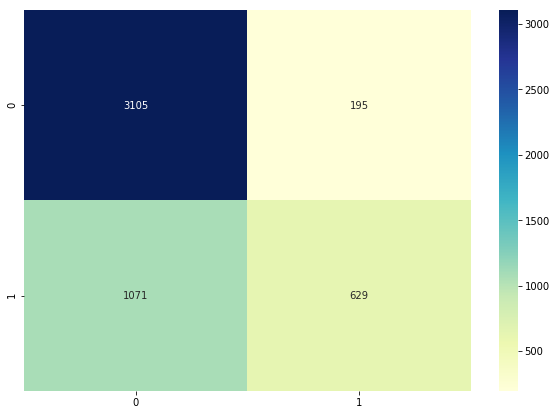

In [34]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

In [35]:
df_pred_class.groupby(['Pred']).count()

,Image,Actual,True_Label,DR_Positive_Proba
Pred,,,,
0,4176,4176,4176,4176
1,824,824,824,824


In [36]:
val_image_class_proba_list = calc_proba_list(model,valList,val=1)
df_pred_val_class = get_pred_df(image_class_proba_list)
df_val_class_tp = df_pred_val_class[(df_pred_val_class.Pred>0)&(df_pred_val_class.Actual==df_pred_val_class.Pred)]
df_val_class_tn = df_pred_val_class[(df_pred_val_class.Pred==0)&(df_pred_val_class.Actual==df_pred_val_class.Pred)]
df_val_class_fp = df_pred_val_class[(df_pred_val_class.Pred>0)&(df_pred_val_class.Actual!=df_pred_val_class.Pred)]
df_val_class_fn = df_pred_val_class[(df_pred_val_class.Pred==0)&(df_pred_val_class.Actual!=df_pred_val_class.Pred)]

TN: 3118,FP: 182, FN: 1115, TP:585


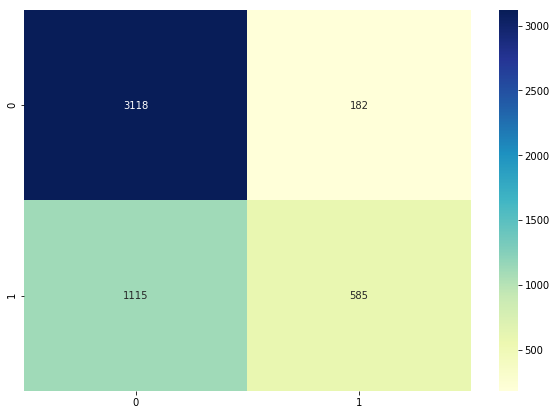

In [37]:
val_image_class_proba_arr = np.vstack(val_image_class_proba_list)
val_image_class_arr = np.argmax(val_image_class_proba_arr,axis=1)

cnf_val = confusion_matrix(val_labels, val_image_class_arr)
tn,fp,fn,tp = cnf_val.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf_val, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

## Load the best model and repeat

In [38]:
model_vgg = load_model('./model_architecture_vgg_2019-04-0135K_aug.json',
                           './best_model.h5')

In [39]:
image_class_proba_list = calc_proba_list(model_vgg,testList)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 3194,FP: 106, FN: 986, TP:714


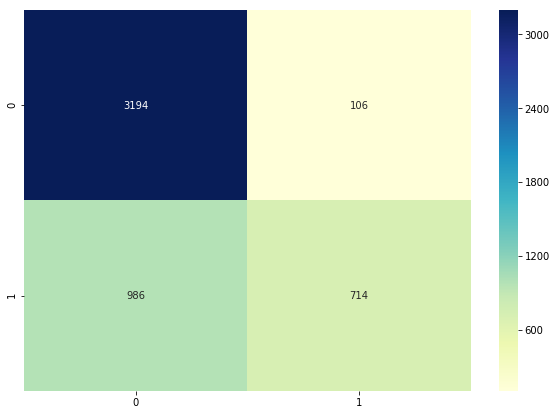

In [40]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

### Run with last epoch instead of best model

In [41]:
model_vgg = load_model('./model_architecture_vgg_2019-04-0135K_aug.json',
                           './model_weights_vgg_2019-04-0135K_aug.h5')

In [42]:
image_class_proba_list = calc_proba_list(model_vgg,testList)
df_pred_class = get_pred_df(image_class_proba_list)
df_class_tp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_tn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual==df_pred_class.Pred)]
df_class_fp = df_pred_class[(df_pred_class.Pred>0)&(df_pred_class.Actual!=df_pred_class.Pred)]
df_class_fn = df_pred_class[(df_pred_class.Pred==0)&(df_pred_class.Actual!=df_pred_class.Pred)]

TN: 3105,FP: 195, FN: 1071, TP:629


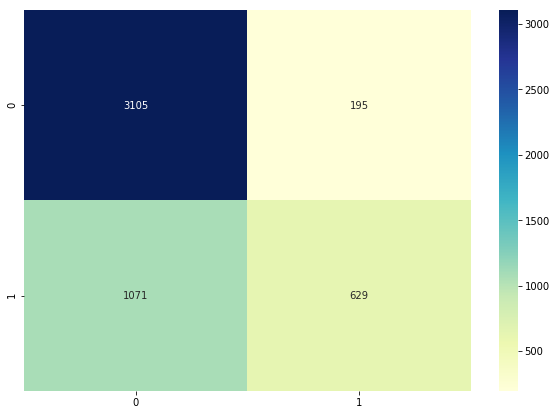

In [43]:
image_class_proba_arr = np.vstack(image_class_proba_list)
image_class_arr = np.argmax(image_class_proba_arr,axis=1)

cnf = confusion_matrix(test_labels, image_class_arr)
tn,fp,fn,tp = cnf.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

In [44]:
val_image_class_proba_list = calc_proba_list(model,valList,val=1)
df_pred_val_class = get_pred_df(image_class_proba_list)
df_val_class_tp = df_pred_val_class[(df_pred_val_class.Pred>0)&(df_pred_val_class.Actual==df_pred_val_class.Pred)]
df_val_class_tn = df_pred_val_class[(df_pred_val_class.Pred==0)&(df_pred_val_class.Actual==df_pred_val_class.Pred)]
df_val_class_fp = df_pred_val_class[(df_pred_val_class.Pred>0)&(df_pred_val_class.Actual!=df_pred_val_class.Pred)]
df_val_class_fn = df_pred_val_class[(df_pred_val_class.Pred==0)&(df_pred_val_class.Actual!=df_pred_val_class.Pred)]

TN: 3118,FP: 182, FN: 1115, TP:585


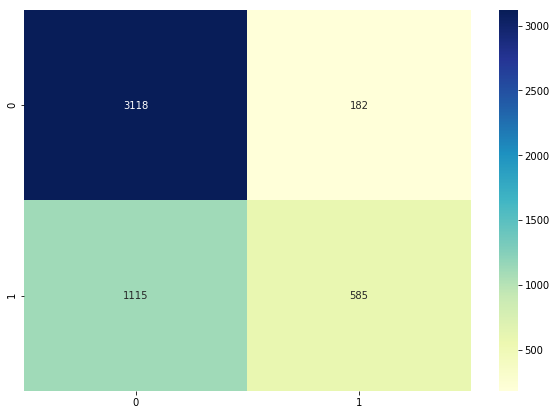

In [45]:
val_image_class_proba_arr = np.vstack(val_image_class_proba_list)
val_image_class_arr = np.argmax(val_image_class_proba_arr,axis=1)

cnf_val = confusion_matrix(val_labels, val_image_class_arr)
tn,fp,fn,tp = cnf_val.ravel()
print("TN: {},FP: {}, FN: {}, TP:{}".format(tn,fp,fn,tp))
df_cm = pd.DataFrame(cnf_val, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

## Plot the history

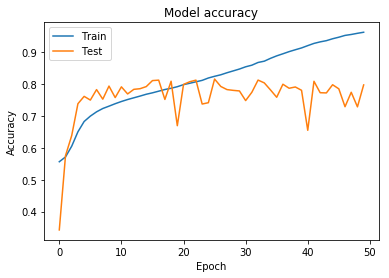

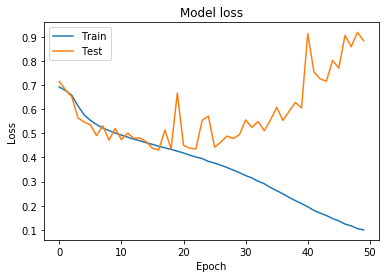

In [46]:
# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()